# Time dependent PRF prior

In this notebook we explore the possibility of a time-dependent PRF prior.  This feature is needed for assigning an RA-DEC center to crowded field photometry in the presence of spacecraft-induced motion.  See [Issue #95](https://github.com/KeplerGO/lightkurve/issues/95).

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from lightkurve import KeplerTargetPixelFile
import numpy as np

### Good sources for demo-ing PRF photometry
Wide binary stars that could be useful, from [GO proposals by Lepine](https://keplerscience.arc.nasa.gov/data/k2-programs/GO14041.txt):
- 201862695
- 201862814

More aparent binaries identified by AMC:
- 224379078 (dynamic background)
- 224290871 (blended ~ 2 pixels)
- 224308921

In [3]:
tpf = KeplerTargetPixelFile.from_archive('248662696')

INFO: Found cached file ./mastDownload/K2/ktwo248662696-c14_lc/ktwo248662696-c14_lpd-targ.fits.gz with expected size 5304878. [astroquery.query]


In [4]:
from astropy.coordinates import SkyCoord

In [5]:
import astropy.units as u

In [6]:
val = SkyCoord('10 42 24.600 +07 26 06.31', unit=(u.hourangle, u.deg))

In [7]:
val.ra.value, val.dec.value

(160.60249999999996, 7.4350861111111115)

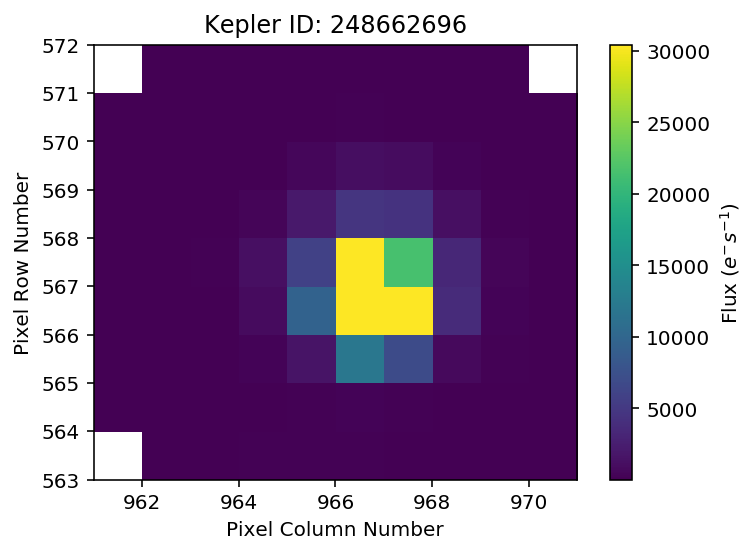

In [8]:
tpf.plot(frame=1853)

There must exist--for every TPF--one frame for which the WCS solution is *exact*.  All other frames possess small $\Delta x$ and $\Delta y$ shifts from the WCS.  We assign the name **"fiducial frame"** to the frame with $\Delta x$ and $\Delta y$ $=0$.

In [9]:
pos_mask = ((tpf.pos_corr1 == 0) & (tpf.pos_corr2 == 0))

In [10]:
np.where(pos_mask)

(array([1853]),)

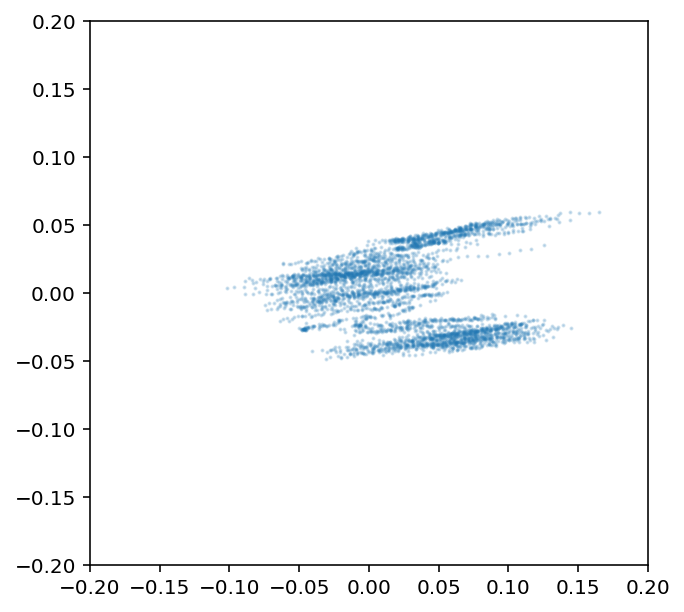

In [11]:
plt.figure(figsize=(5, 5))
plt.plot(tpf.pos_corr1, tpf.pos_corr2, '.', alpha=0.2, ms=2)
plt.ylim(-0.2, 0.2)
plt.xlim(-0.2, 0.2);

### Run the PRF photometry

You need to import from "oktopus" which contains optimization code.

In [12]:
from lightkurve import KeplerTargetPixelFile, SimpleKeplerPRF, SceneModel, PRFPhotometry
from oktopus import UniformPrior
import oktopus

In [13]:
prf = tpf.get_prf_model()

The spacecraft jitters around by fractions of a pixel.  
We want to move the prior to keep the target window in the same place *on the sky*.  
We'll start with a single PRF model.  The **scene** contains a single PRF for now.

In [14]:
scene = SceneModel(prfs=1*[prf])

Eventually we want to change the code to look like this suggestion from Geert:

```Python 
sp = StarPrior(ra, dec, flux, pos_uncertainty)
scene = SceneModel(stars=[sp1, sp2, sp3], bg)
scene.fit(tpf)
```

For now, we will develop a pre-processing function that takes in:
- WCS (or even more abstractly, a TPF object)
- RA center
- DEC center
- uncertainty width 
- (optionally?) flux minimum and maximum

The function returns an `oktopus` prior of type `UniformPrior` or `GaussianPrior`.  The function will require some additional astropy imports, probably placed the top of the script.

In [15]:
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from oktopus import GaussianPrior, UniformPrior

Here is the code we added to prf.py:

```python
def ra_dec_to_prior(tpf, ra, dec, flux, width, bg, bg_width=500, prior_type=None):
    '''Returns an oktopus prior object given input RA, DEC, etc
    
        Note: Assumes input RA, DEC is in ICRS degrees
    '''
    skyposition = SkyCoord(ra, dec, unit=('deg','deg'), frame='icrs')
    wcs = tpf.wcs
    prior_x, prior_y = skycoord_to_pixel(skyposition, wcs=wcs)
    prior_x += tpf.column
    prior_y += tpf.row
    width_in_pix = width / (tpf.wcs.wcs.cdelt[1]*3600.0)
    if (prior_type == None) | (prior_type == 'uniform') | (prior_type == 'Uniform'):
        flux_lower = np.sqrt(flux)
        flux_upper = 2.0*flux
        bg_lower = bg-bg_width
        bg_upper = bg+bg_width
        prior_out = UniformPrior(lb=[flux_lower, prior_x-width_in_pix, 
                                     prior_y-width_in_pix, bg_lower], 
                                 ub=[flux_upper, prior_x+width_in_pix,
                                     prior_y+width_in_pix, bg_upper])
    if (prior_type == 'gaussian') | (prior_type == 'Gaussian'):
        prior_out = GaussianPrior([flux, prior_x, prior_y, bg], [np.sqrt(flux), width, width,bg_width])
    return prior_out
```

In [16]:
ra, dec = 160.60249999999996, 7.4350861111111115

In [17]:
from lightkurve.prf import ra_dec_to_prior

In [18]:
prior = ra_dec_to_prior(tpf, ra, dec, 500000, 1.0, 8.0, bg_width=10000, prior_type='uniform')

In [19]:
phot = PRFPhotometry(scene, prior)

### RA DEC experiments

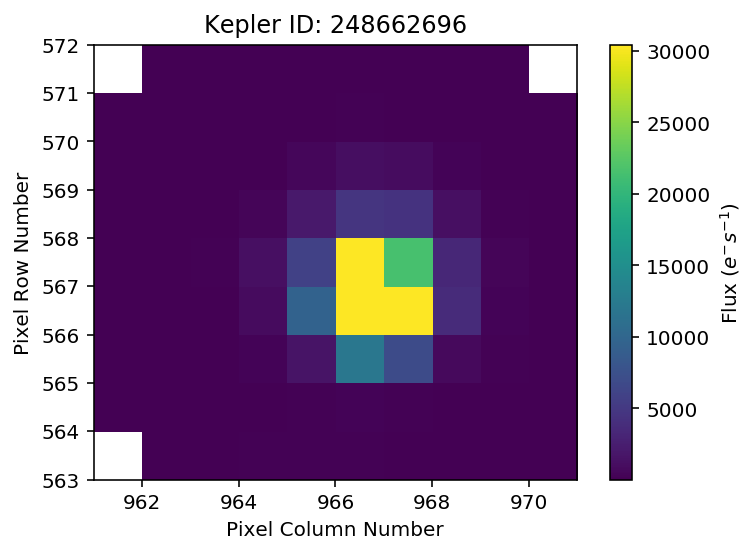

In [20]:
tpf.plot(frame=1853)

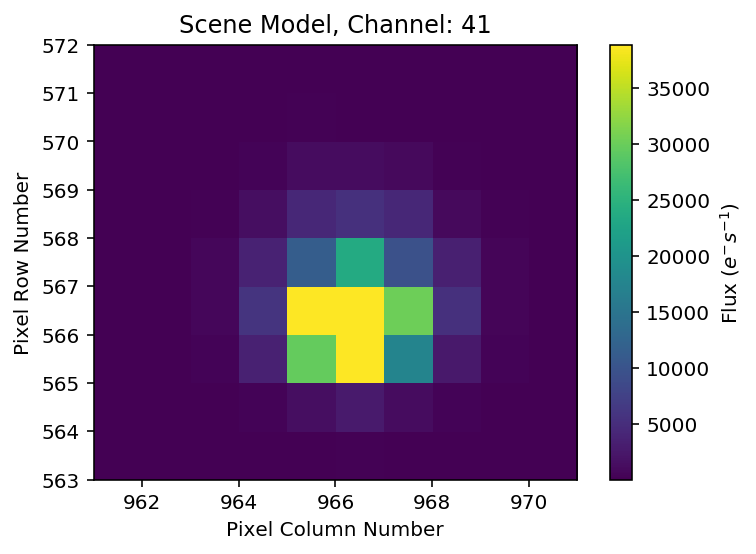

In [21]:
scene.plot(*prior.mean)

In [22]:
results = phot.fit(tpf) # doctest: +SKIP

  0%|          | 0/3694 [00:00<?, ?it/s]/Users/obsidian/anaconda3/lib/python3.6/site-packages/autograd/core.py:69: RuntimeWarning: invalid value encountered in log
  result_value = self.fun(*argvals, **kwargs)
/Users/obsidian/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/obsidian/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
 19%|█▉        | 711/3694 [00:20<01:24, 35.14it/s]/Users/obsidian/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1926: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/obsidian/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2573: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/Users/obsidian/anaconda3/lib

In [23]:
results.shape

(3694, 4)

In [26]:
lc = tpf.to_lightcurve(aperture_mask='all')

In [27]:
lc.flux

array([313398.75, 313360.72, 313389.3 , ..., 313428.5 , 313445.22,
       313486.62], dtype=float32)

(0.98, 1.01)

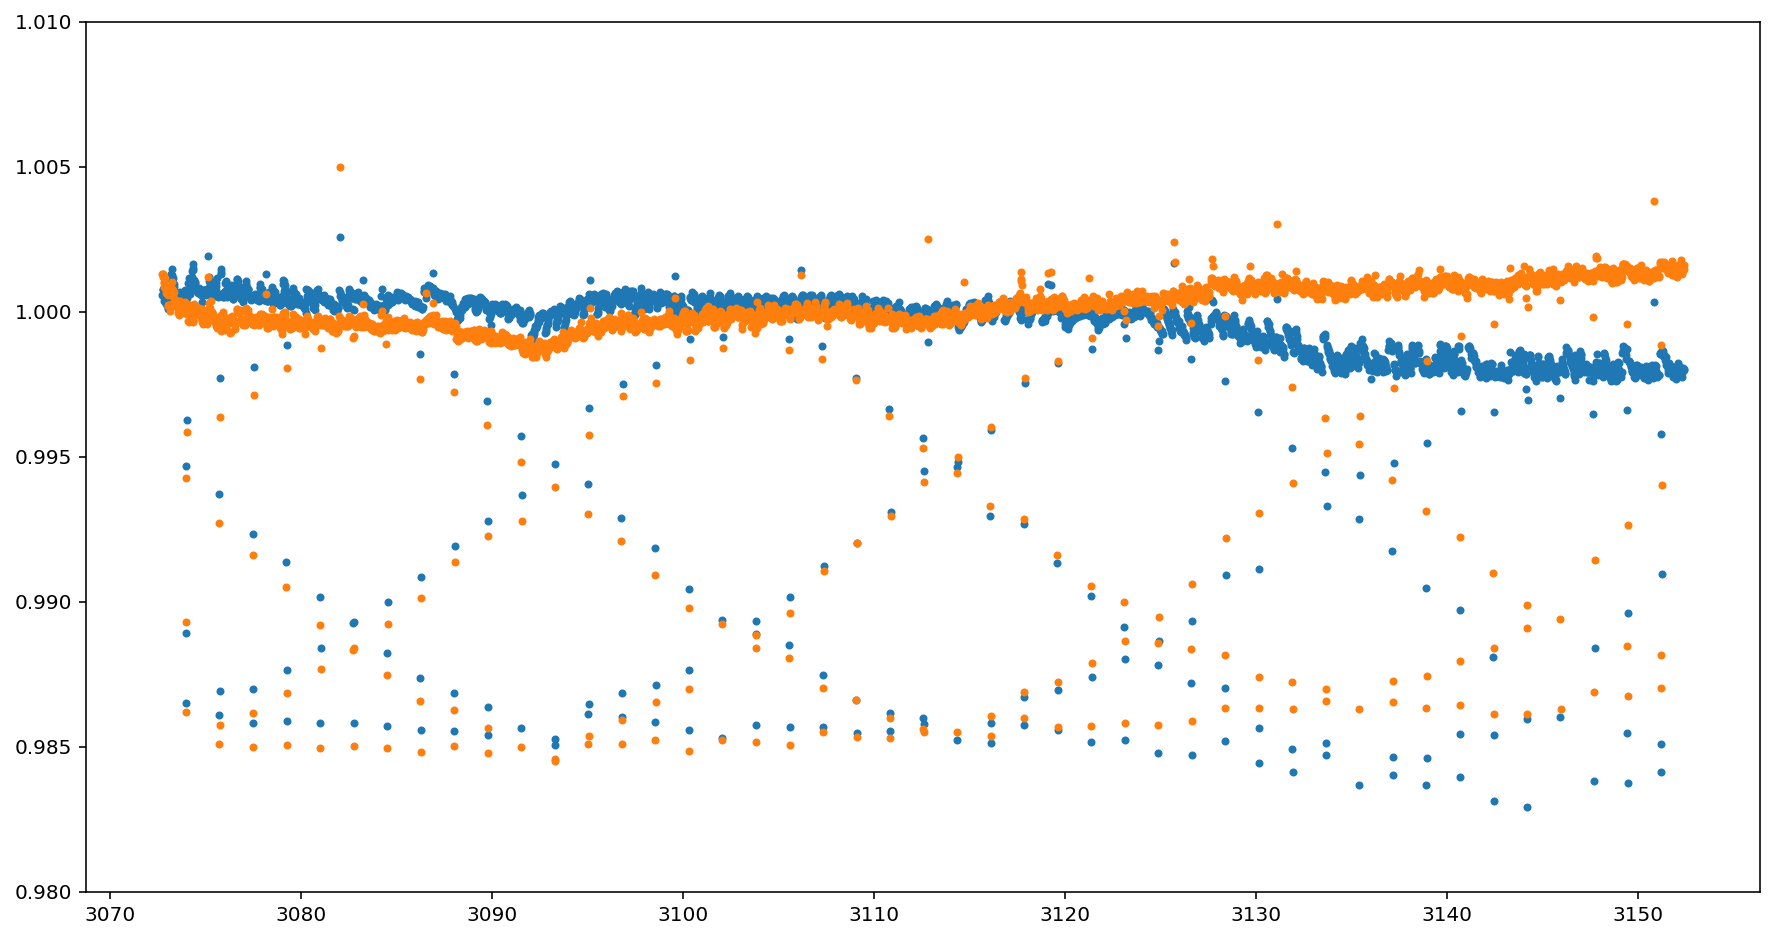

In [28]:
plt.figure(figsize=(15, 8))
plt.plot(tpf.time, results[:, 0]/np.nanmedian(results[:, 0]), '.')
plt.plot(tpf.time, lc.flux/np.nanmedian(lc.flux), '.')

plt.ylim(0.98, 1.01)

In [30]:
dx, dy = results[:, 1], results[:, 2]

In [31]:
dx

array([966.67183971, 966.67806668, 966.68497443, ..., 966.76373697,
       966.77180273, 966.77933154])

(966.5, 967)

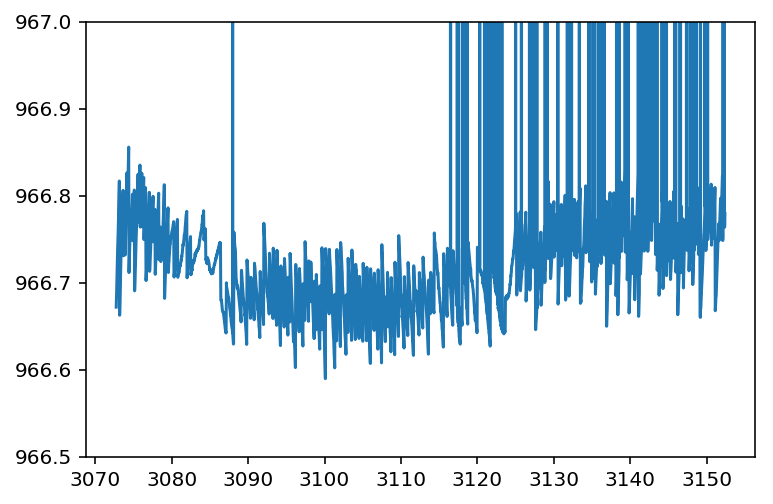

In [32]:
plt.plot(tpf.time, dx, ms=1)
plt.ylim(966.5, 967)

What is the cause of the failures?

In [34]:
mask = (results[:, 0]/np.nanmedian(results[:, 0]) > 1.2)

In [35]:
mask.sum()

78

In [36]:
np.where(mask)

(array([ 713, 2037, 2079, 2086, 2088, 2111, 2123, 2129, 2136, 2138, 2216,
        2247, 2265, 2286, 2303, 2326, 2332, 2344, 2357, 2441, 2476, 2527,
        2547, 2552, 2570, 2621, 2635, 2697, 2753, 2761, 2779, 2825, 2884,
        2908, 2913, 2939, 2956, 2974, 3049, 3065, 3100, 3119, 3179, 3180,
        3186, 3187, 3204, 3222, 3229, 3247, 3255, 3263, 3269, 3276, 3279,
        3289, 3320, 3324, 3340, 3345, 3346, 3395, 3398, 3401, 3428, 3430,
        3465, 3466, 3487, 3508, 3510, 3523, 3547, 3575, 3579, 3590, 3682,
        3689]),)

In [37]:
tpf.flux[713]

array([[           nan, 4.36879463e+01, 7.33870010e+01, 1.28619965e+02,
        1.45239609e+02, 1.57318710e+02, 8.44844131e+01, 5.86526375e+01,
        4.48309708e+01, 3.81121368e+01],
       [2.58165493e+01, 2.91673565e+01, 5.38091393e+01, 9.71891708e+01,
        1.34620102e+02, 3.22997345e+02, 2.08181381e+02, 9.59317398e+01,
        6.44968719e+01, 2.81302032e+01],
       [2.42187862e+01, 4.22104454e+01, 7.95036621e+01, 2.30842575e+02,
        1.43936426e+03, 1.23245420e+04, 5.82562695e+03, 5.97719543e+02,
        1.13804901e+02, 4.74129295e+01],
       [2.67172470e+01, 5.26055069e+01, 1.20923172e+02, 7.42489990e+02,
        1.05530811e+04, 1.32023969e+05, 5.80870000e+04, 2.75978662e+03,
        2.47773407e+02, 6.48845978e+01],
       [1.56170931e+01, 3.09111671e+01, 1.40530655e+02, 1.06829395e+03,
        6.04008496e+03, 3.88632852e+04, 2.05945430e+04, 2.76217188e+03,
        3.13083252e+02, 5.78909531e+01],
       [1.26248064e+01, 2.17798786e+01, 6.64491196e+01, 3.15574066e+02,
   

The end.